# Model Prediksi Views, Like, dan Jumlah Komentar Video Youtube 

   YouTube adalah sebuah situs web yang berfungsi sebagai sarana untuk berbagi video. YouTube telah menjadi suatu bagian yang penting dalam kehidupan kita sehari-hari. Seiring dengan perkembangan teknologi, semakin banyak orang menggunakan YouTube, baik untuk kesenangan pribadi maupun sebagai sumber penghasilan dengan pekerjaan yang disebut influencer. Influencer memperoleh penghasilannya berdasarkan interaksi yang terjadi dalam video mereka, seperti banyaknya view yang ada. Semakin banyak orang yang menonton suatu video di YouTube, maka semakin besar penghasilannya. 
   
   Trending merupakan fitur yang sangat berpengaruh pada YouTube. Melalui fitur  Trending,  sebuah video dapat dengan cepat tersebar dan dapat menambah jumlah views, likes, dan komentar secara drastis sehingga fitur Trending sering kali menjadi tolak ukur keberhasilan ketika membuat sebuah video. Pada projek ini, kami ingin mengetahui model terbaik yang dapat memprediksi jumlah view, like, dan komentar pada suatu video dengan menggunakan Linear Regression (dengan dan tanpa transformasi logaritma pada data) dan Random Forest.

## 1. Data
   Kami menggunakan dataset dari Trending Youtube Video Statistics dari Kaggle dan memilih data video trending yang berasal dari India.  Data dalam video ini adalah hasil rekap pada tahun 2017 sampai 2018. Data video trending tersebut tersimpan dalam file CSV dan memiliki banyak feature, seperti:
- video_id = ID unik video tersebut
- trending_date = tanggal video tersebut mulai trending
- title = judul video
- channel_title = channel yang mempublikasikan video 
- category_id- kategori video tersebut yang disimbolkan dengan angka.
- publish_time = waktu video tersebut di upload
- tags = tag yang digunakan dalam video
- views = jumlah views
- likes = jumlah likes
- dislikes = jumlah dislikes
- comment_count jumlah comments

### 1.1  Persiapan Data
Sebagai persiapan, kami akan meng-install library yang akan digunakan, terutama pandas untuk analisis data dan matplotlib untuk visualisasi data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import json
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from nltk.stem import PorterStemmer
import nltk
from sklearn.metrics import r2_score

Kemudian, kita akan membaca data tersebut dan menampilkan lima data teratas

In [2]:
youtube=pd.read_csv("INvideos.csv")

In [3]:
youtube.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...
1,zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं..."
2,10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...
3,N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...
4,kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...


In [4]:
print(youtube.shape)

(37352, 16)


Dapat dilihat bahwa dataset ini memiliki 37352 baris dan 16 kolom. Sekarang kita akan melihat tipe data yang kita miliki

### 1.2 Pembersihan Data
Sekarang, kita akan melakukan proses cleansing/pembersihan data, di mana baris yang memiliki element tidak lengkap, akan dihapus.

In [5]:
print(youtube.isnull().values.any())

True


In [6]:
youtube = youtube.dropna(how='any',axis=0)

Kita juga tidak membutuhkan informasi mengenai id video dan link thumbnail video tersebut, maka akan dihapus.

In [7]:
youtube.drop(['video_id','thumbnail_link'],axis=1,inplace=True)

## 2. EDA (Exploratory Data Analysis)

#### Tahun Pengumpulan Data 

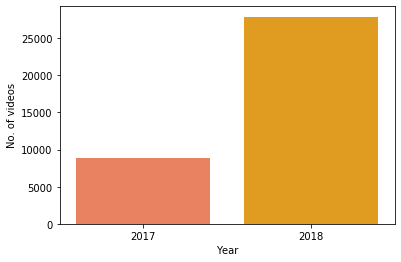

In [8]:
youtube_collection_years= youtube["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})

fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=youtube_collection_years, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos")

In [9]:
youtube["trending_date"].apply(lambda x: '20' + x[:2]).value_counts(normalize=True)

2018    0.758501
2017    0.241499
Name: trending_date, dtype: float64

Dapat dilihat bahwa sekitar 24% dataset ini dikumpulkan pada tahun 2017 dan 75% nya dikumpulkan pada 2018

#### Informasi Statistik
Sekarang, mari kita lihat informasi statistika pada kolom yang memiliki nilai dalam bentuk angka

In [10]:
youtube.describe()

,category_id,views,likes,dislikes,comment_count
count,36791.000000,3.679100e+04,3.679100e+04,3.679100e+04,36791.000000
mean,21.552173,1.071490e+06,2.745069e+04,1.685363e+03,2714.022043
std,6.586716,3.207149e+06,9.783129e+04,1.619732e+04,14978.114328
min,1.000000,4.024000e+03,0.000000e+00,0.000000e+00,0.000000
25%,23.000000,1.256040e+05,8.790000e+02,1.090000e+02,83.000000
50%,24.000000,3.078360e+05,3.126000e+03,3.310000e+02,336.000000
75%,24.000000,8.066315e+05,1.409500e+04,1.032000e+03,1314.500000
max,43.000000,1.254322e+08,2.912710e+06,1.545017e+06,827755.000000


Dari tabel tersebut dapat dilihat bahwa 
- Rata-rata orang yang menonton (views) video trending adalah 1.071.490. Median dari views adalah 307.836, yang berarti setengah dari trending video yang ada ditonton dengan jumlah views kurang dari median tersebut, dan sisanya lagi ditonton dengan jumlah angka lebih besar
- Rata-rata likes adalah 27.450,79
- Rata-rata jumlah komentar (comment_count) adalah 2714,022043 

Kita akan melihat ada berapa unik data pada setiap kolom

In [11]:
youtube.apply(lambda x: len(x.unique()))

trending_date               205
title                     16431
channel_title              1390
category_id                  17
publish_time              16053
tags                      12463
views                     31638
likes                     15473
dislikes                   5072
comment_count              6024
comments_disabled             2
ratings_disabled              2
video_error_or_removed        2
description               13992
dtype: int64

#### Persebaran Video
Sekarang, kita akan melihat persebaran video berdasarkan jenis kategori. Pertama, kita harus membuat kolom terlebih dahulu yang memuat nama kategori. Kita akan membuat kategori dengan file Json yang memuat informasi mengenai setiap kategori.

In [12]:
with open("IN_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
youtube['category_name'] = youtube['category_id'].map(cat_dict)

Entertainment           16462
News & Politics          5173
Music                    3857
Comedy                   3407
People & Blogs           2494
Film & Animation         1649
Education                1180
Howto & Style             837
Sports                    712
Science & Technology      548
Shows                     205
Autos & Vehicles           69
Gaming                     66
Movies                     16
Travel & Events             8
Pets & Animals              3
Name: category_name, dtype: int64


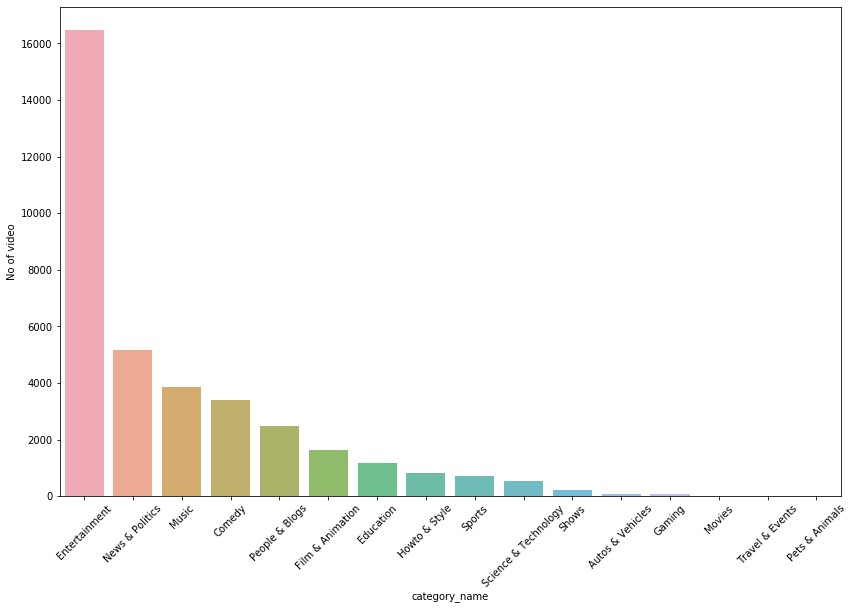

In [13]:
count=youtube.category_name.value_counts()
print(count)
plt.figure(figsize=(14,9))
graph = sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('No of video')
plt.xlabel('category_name')
graph.set_xticklabels(graph.get_xticklabels(),rotation=45)
plt.show()

Dapat dilihat bahwa dataset ini memuat paling banyak video dengan kategori Entertainment.

False    35611
True      1180
Name: comments_disabled, dtype: int64


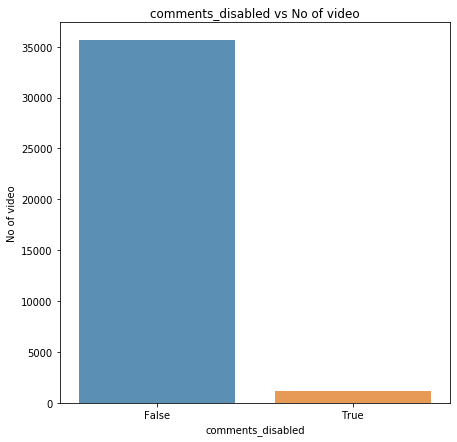

False    36034
True       757
Name: ratings_disabled, dtype: int64


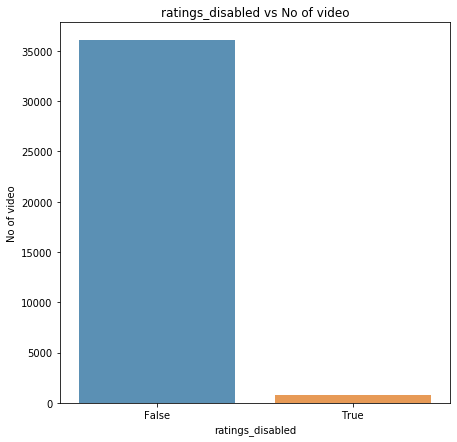

False    36780
True        11
Name: video_error_or_removed, dtype: int64


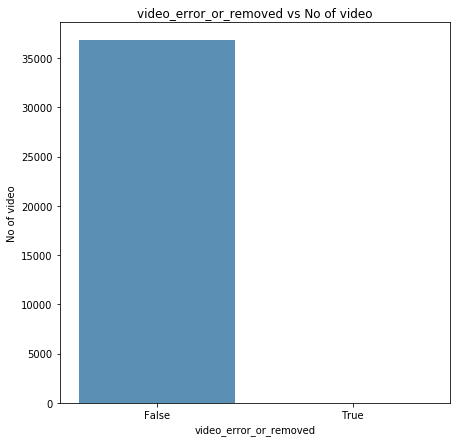

In [14]:
for x in (['comments_disabled','ratings_disabled','video_error_or_removed']):
    count=youtube[x].value_counts()
    print(count)
    plt.figure(figsize=(7,7))
    sns.barplot(count.index, count.values, alpha=0.8)
    plt.title('{} vs No of video'.format(x))
    plt.ylabel('No of video')
    plt.xlabel('{}'.format(x))
    plt.show()

Selain itu, dataset ini juga memuat lebih banyak data video yang tidak dimatikan fitur comment dan ratingnya. Video-video trending yang ada pun juga tidak error maupun dihapus.

#### Distribusi views

Sekarang, kita akan melihat bagaimana persebaran views

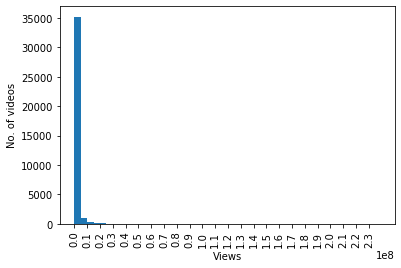

In [15]:
fig, ax = plt.subplots()
_ = sns.distplot(youtube["views"], kde=False, 
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.3e8, 47), ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax.set_xlim(right=2.5e8)
_ = plt.xticks(rotation=90)

Dapat kita lihat bahwa distribusi jumlah vieww terhadap jumlah video berbentuk right skewed dan mayoritas video yang trending memiliki views sebanyak kurang dari 100 juta 
Sekarang kami akan melakukan plot dengan histogram khusus untuk video dengan views kurang dari 10 juta untuk melihat distribusi data

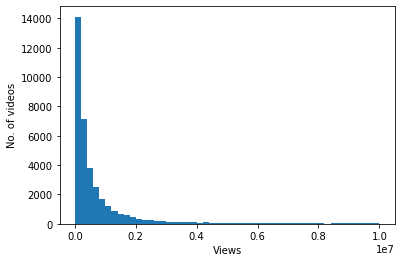

In [16]:
fig, ax = plt.subplots()
_ = sns.distplot(youtube[youtube["views"] < 1e7]["views"], kde=False, hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos")

Dapat dilhat bahwa mayoritas video yang trending memiliki views kurang dari 1 juta. Sekarang, kita akan melihat bagaimana persentase video kurang dari 1 juta views

In [17]:
youtube[youtube['views'] < 1e6]['views'].count() / youtube['views'].count() * 100

79.37539072055667

Dapat dilihat bahwa 79% video memiliki views kurang dari 1 juta

#### Persebaran Likes

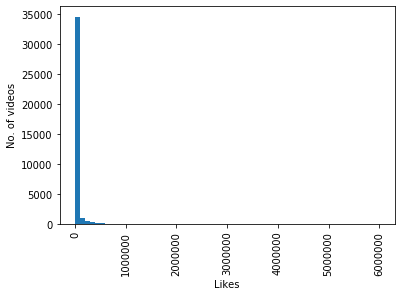

In [18]:
plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(youtube["likes"], kde=False, hist_kws={'alpha': 1},bins=np.linspace(0, 6e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")
_ = plt.xticks(rotation=90)

Dapat kita lihat bahwa distribusi jumlah likes terhadap jumlah video berbentuk right skewed dan mayoritas video yang trending memiliki likes sebanyak kurang dari 200.000
Sekarang kami akan melakukan plot dengan histogram khusus untuk video dengan likes kurang dari 200.000 untuk melihat distribusi data

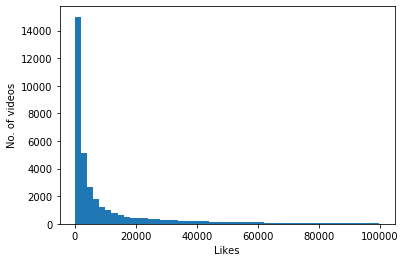

In [19]:
fig, ax = plt.subplots()
_ = sns.distplot(youtube[youtube["likes"] <= 1e5]["likes"], kde=False, hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")

Dapat dilhat bahwa mayoritas video yang trending memiliki likes kurang dari 20 ribu. Sekarang, kita akan melihat bagaimana persentase video kurang dari 20 ribu likes

In [20]:
youtube[youtube['likes'] < 2e4]['likes'].count() / youtube['likes'].count() * 100

79.03291565872088

Dapat dilihat bahwa 79% video memiliki likes kurang dari 20 ribu likes

#### Persebaran Jumlah Komentar

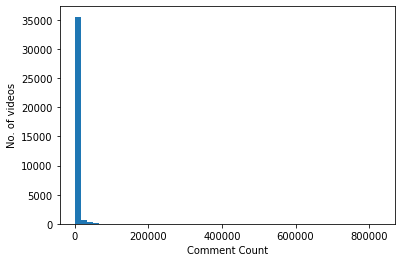

In [21]:
fig, ax = plt.subplots()
_ = sns.distplot(youtube["comment_count"], kde=False, rug=False, hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos")

Dapat kita lihat bahwa distribusi jumlah komentar terhadap banyaknya video berbentuk right skewed dan mayoritas video yang trending memiliki jumlah komentar kurang dari 20.000
Sekarang kami akan melakukan plot dengan histogram khusus untuk video dengan jumlah komentar kurang dari 20.000 untuk melihat distribusi data

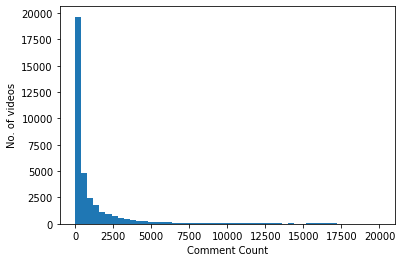

In [22]:
fig, ax = plt.subplots()
_ = sns.distplot(youtube[youtube["comment_count"] <= 2e4]["comment_count"], kde=False, hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos")

Dapat dilhat bahwa mayoritas video yang trending memiliki jumlah komentar kurang dari 500. Sekarang, kita akan melihat bagaimana persentase video kurang dari 500 komentar

In [23]:
youtube[youtube['comment_count'] < 5e2]['comment_count'].count() / youtube['comment_count'].count() * 100

57.85654100187546

Dapat dilihat bahwa 58% video memiliki jumlah komentar kurang dari 500

#### Persebaran Jumlah Dislikes

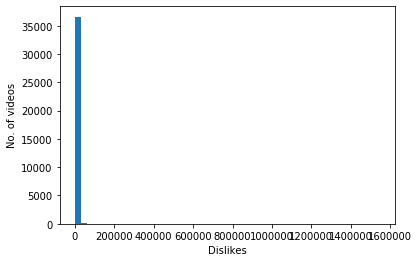

In [24]:
fig, ax = plt.subplots()
_ = sns.distplot(youtube["dislikes"], kde=False, rug=False, hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Dislikes", ylabel="No. of videos")

Dapat kita lihat bahwa distribusi jumlah dislikes terhadap banyaknya video berbentuk right skewed dan mayoritas video yang trending memiliki jumlah dislikes kurang dari 50.000
Sekarang kami akan melakukan plot dengan histogram khusus untuk video dengan jumlah dislikes kurang dari 50.000 untuk melihat distribusi data

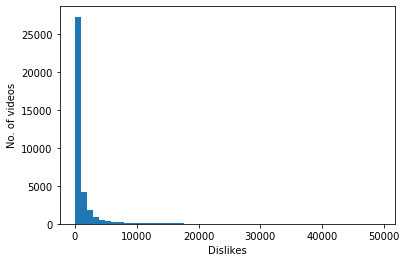

In [25]:
fig, ax = plt.subplots()
_ = sns.distplot(youtube[youtube["dislikes"] <= 5e4]["dislikes"], kde=False, hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Dislikes", ylabel="No. of videos")

Dapat dilhat bahwa mayoritas video yang trending memiliki jumlah dislikes kurang dari 1000. Sekarang, kita akan melihat bagaimana persentase video kurang dari 1000

In [26]:
youtube[youtube['dislikes'] < 1e3]['comment_count'].count() / youtube['comment_count'].count() * 100

74.32252453045581

Dapat dilihat bahwa 74% video memiliki dislikes kurang dari 1000

## 3. Feature Engineering
Dalam Feature Engineering, kita akan menambahkan feature yang diperlukan untuk proses modelling nanti

#### Menghitung jumlah tag

In [27]:
tags=[x.count("|")+1 for x in youtube["tags"]]
youtube["No_tags"]=tags

#### Menghitung panjang deskripsi

In [28]:
desc_len=[len(x) for x in youtube["description"]]
youtube["desc_len"]=desc_len

#### Menghitung panjang judul 

In [29]:
title_len=[len(x) for x in youtube["title"]]
youtube["len_title"]=title_len

#### Mengubah bentuk tanggal dan hari publikasi video dari string  ke dalam variable datetime

In [30]:
publish_time = pd.to_datetime(youtube['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
youtube['publish_time'] = publish_time.dt.time
youtube['publish_date'] = publish_time.dt.date

In [31]:
youtube['publish_weekday']=publish_time.dt.day_name()

#### Mengubah hari publikasi video dari bentuk string ke integer

In [32]:
youtube['publish_weekday'] = youtube['publish_weekday'].replace({'Monday':1,
                                                             'Tuesday':2,
                                                             'Wednesday':3,
                                                             'Thursday':4,
                                                             'Friday':5,
                                                             'Saturday':6,
                                                             'Sunday':7})

5    6097
6    5636
4    5554
1    5263
2    5180
3    5035
7    4026
Name: publish_weekday, dtype: int64


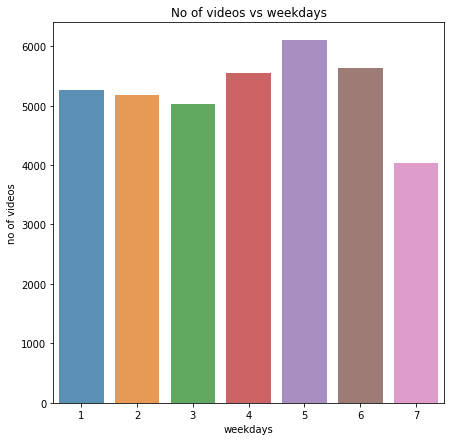

In [33]:
count=youtube["publish_weekday"].value_counts()
print(count)
plt.figure(figsize=(7,7))
sns.barplot(count.index, count.values, alpha=0.8)
plt.title('No of videos vs weekdays')
plt.ylabel('no of videos')
plt.xlabel('weekdays')
plt.show()

Kita dapat melihat bahwa video yang trending lebih banyak dipublikasi pada hari ke-5 atau Jumat

#### Melakukan log transform
Sebelumnya kita telah mengetahui bahwa distribusi dari views, likes, dislikes, dan jumlah komentar kita adalah right skewed. Padahal, untuk melakukan linear regression sangat disarankan untuk memiliki data yang berdistribusi normal agar memiliki hasil optimal. Oleh karena itu kita akan mengubah feature tersebut dalam bentuk logaritma

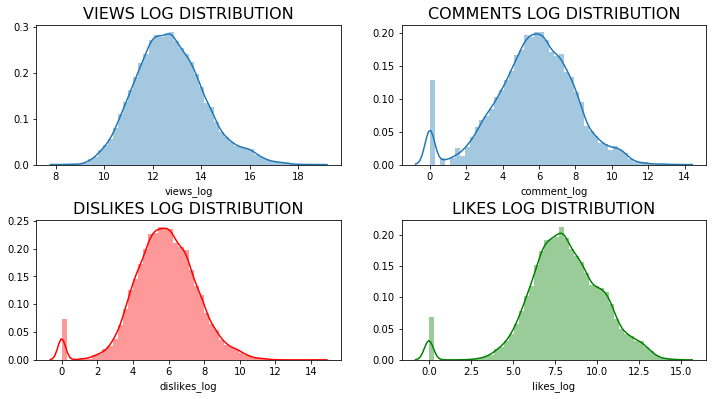

In [34]:
youtube['likes_log'] = np.log(youtube['likes'] + 1)
youtube['views_log'] = np.log(youtube['views'] + 1)
youtube['dislikes_log'] = np.log(youtube['dislikes'] + 1)
youtube['comment_log'] = np.log(youtube['comment_count'] + 1)

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(youtube['views_log'])
g1.set_title("VIEWS LOG DISTRIBUTION", fontsize=16)

plt.subplot(224)
g2 = sns.distplot(youtube['likes_log'],color='green')
g2.set_title('LIKES LOG DISTRIBUTION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(youtube['dislikes_log'], color='r')
g3.set_title("DISLIKES LOG DISTRIBUTION", fontsize=16)

plt.subplot(222)
g4 = sns.distplot(youtube['comment_log'])
g4.set_title("COMMENTS LOG DISTRIBUTION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

Dapat dilihat bahwa bentuk distribusinya lebih baik daripada sebelumnya, yaitu sudah berbentuk distribusi normal.

#### Menghitung rasio
Kami akan membuat kolom baru yang memuat rasio dari views dan likes, ratio view dan dislikes, ratio jumlah view dan comment, dan ratio likes dan dislikes dengan perhitungan 3 angka penting

In [35]:
youtube["Ratio_View_likes"]=round(youtube["views"]/youtube["likes"],3)

youtube["Ratio_View_dislikes"]=round(youtube["views"]/youtube["dislikes"],3)

youtube["Ratio_views_comment_count"]=round(youtube["views"]/youtube["comment_count"],3)

youtube["Ratio_likes_dislikes"]=round(youtube["likes"]/youtube["dislikes"],3)

Kami akan membuat kolom baru yang memuat rasio dari log views dan log likes, ratio log view dan log dislikes, ratio log view dan log jumlah comment, dan ratio log likes dan log dislikes dengan perhitungan 3 angka penting

In [36]:
youtube["Ratio_View_log_likes_log"]=round(youtube["views_log"]/youtube["likes_log"],3)

youtube["Ratio_View_log_dislikes_log"]=round(youtube["views_log"]/youtube["dislikes_log"],3)

youtube["Ratio_views_log_comment_log"]=round(youtube["views_log"]/youtube["comment_log"],3)

youtube["Ratio_likes_log_dislikes_log"]=round(youtube["likes_log"]/youtube["dislikes_log"],3)

In [37]:
print(max(youtube["Ratio_View_likes"]))
print(max(youtube["Ratio_View_dislikes"]))
print(max(youtube["Ratio_views_comment_count"]))
print(max(youtube["Ratio_likes_dislikes"]))
print(max(youtube["Ratio_View_log_likes_log"]))
print(max(youtube["Ratio_View_log_dislikes_log"]))
print(max(youtube["Ratio_views_log_comment_log"]))
print(max(youtube["Ratio_likes_log_dislikes_log"]))

inf
inf
inf
inf
inf
inf
inf
inf


Dapat kita lihat bahwa ketika kami ingin mengetahui nilai maksimum dari rasio yang telah dihitung sebelumnya, muncul infinite. Maka kita mengganti data yang mengandung nilai infinite tersebut denga NaN (tidak ada) dan menghapus baris yang memiliki nilai NaN

In [38]:
youtube=youtube.replace([np.inf, -np.inf], np.nan)
youtube = youtube.dropna(how='any',axis=0)

## 4. Matriks Korelasi / Correlation Matrix
Kita akan melihat korelasi antar feature

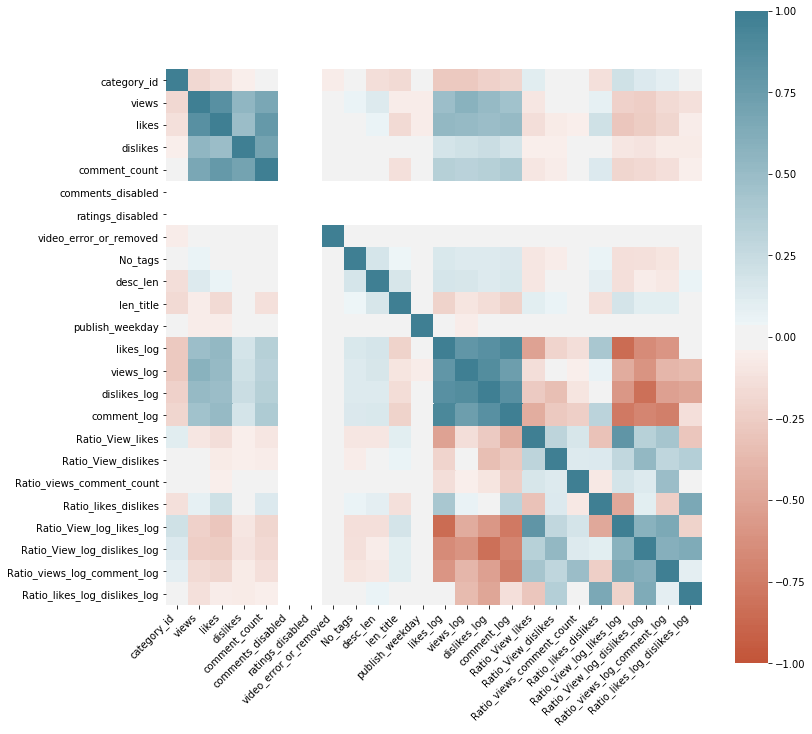

In [39]:
data = youtube

corr = data.corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


Dari matriks korelasidiatas, dapat dilihat bahwa views, likes, dislkes, dan jumlah komentar saling berkorelasi. Selain itu, transformasi logaritmanya pun juga berkorelasi.

Sekarang, kami akan menghapus feature yang tidak dibutuhkan lagi (tidak berkorelasi)

In [40]:
youtube.drop(['trending_date','publish_date','publish_time','tags','title','description','channel_title', 'category_name'],axis=1,inplace=True)

## 5. Model Machine Learning 
### 5.1 Prediksi Jumlah Views

#### 5.1.1 Linear Regression tanpa Transformasi Logaritma

#### Membagi data menjadi train data dan test data dengan ratio 80:20

In [41]:
views=youtube['views']
youtube_view=youtube.drop(['views','views_log','likes_log','comment_log','dislikes_log',
                           'Ratio_View_log_likes_log','Ratio_views_log_comment_log',
                           'Ratio_View_log_dislikes_log','Ratio_likes_log_dislikes_log'],axis=1,inplace=False)

In [42]:
x_train,x_test,y_train,y_test=train_test_split(youtube_view,views, test_size=0.2,shuffle=False)

In [43]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(28031, 15) (7008, 15) (28031,) (7008,)


#### Melakukan Linear Regression

Kami akan memuat library yang akan digunakan untuk melakukan regresi linear terlebih dahulu, lalu melakukan training pada model

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Karena kita melakukan menggunakan banyak feature dalam linear regresi ini, maka regresi ini harus menemukan koefisien optimum untuk setiap feature.

In [45]:
coeff_df = pd.DataFrame(model.coef_, youtube_view.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
category_id,-3.009896e+04
likes,2.945741e+01
dislikes,4.188718e+01
comment_count,-3.767913e+01
comments_disabled,-4.032478e-07
ratings_disabled,1.026130e-06
video_error_or_removed,-3.088517e+06
No_tags,1.061616e+04
desc_len,1.772672e+02
len_title,8.449664e+03


Dari koefisien yang ada, kita bisa melihat pengaruh setiap feature. Setiap tambah 1 unit "likes, maka jumlah views akan bertambah sebanyak 29,45741 unit. Hal ini juga berlaku untuk feature lainnya.

Setelah itu, kami akan melakukan prediksi dengan test set dan membandingkan nilai sebenarnya dengan nilai prediksi

In [46]:
y_pred = model.predict(x_test)
print('Root mean squared error score', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-square score: %.2f' % r2_score(y_test, y_pred))
print("Result :",model.score(x_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

Root mean squared error score 1480236.090962568
R-square score: 0.73
Result : 0.7346180910147193
       True Labels  Predicted Labels
30104      1171185      1.039960e+06
30105      1267640      6.941137e+05
30106      1166148      3.660295e+05
30107       819426      1.678273e+06
30108      1125692      7.231885e+05
...            ...               ...
37347       214378      6.206740e+05
37348       406828     -2.109518e+05
37349       386319      3.759603e+05
37350       130263      1.907395e+05
37351      1278249      8.422168e+05

[7008 rows x 2 columns]


Dapat dilihat bahwa terdapat perbedaan antara nilai prediksi dan nilai hasil.
Nilai RMSE adalah 1.480.236, R-square adalah 0.73. Nilai akurasi dari model ini adalah 73,4%. Dari R-square yang didapat (>0.5) dan nilai akurasi yang cukup tinggi, dapat dilihat bahwa hasil yang didapatkan tidak buruk.

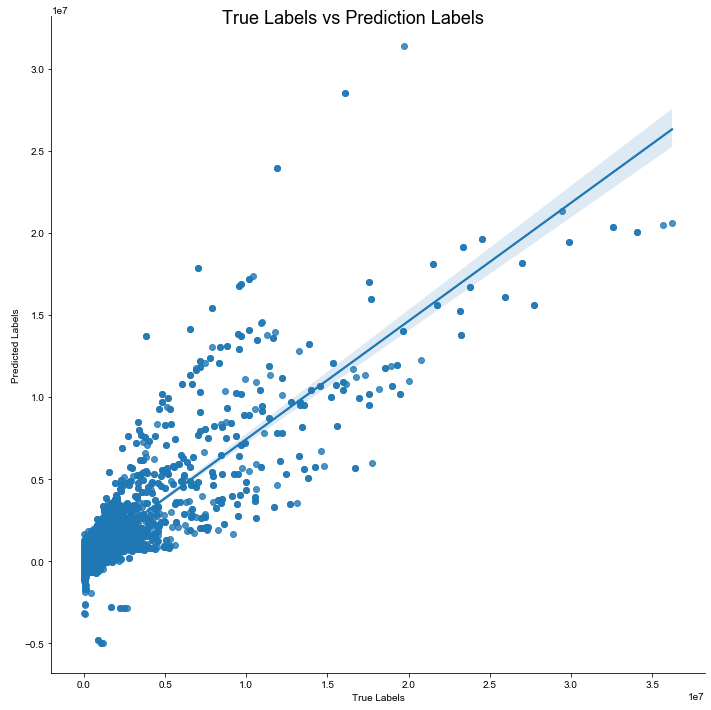

In [47]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
fig1 = lm1.fig 
fig1.suptitle("True Labels vs Prediction Labels ", fontsize=18)
sns.set(font_scale = 1.5)

Dari grafik yang kita lihat, true labels dan predicted label cukup sesuai

#### 5.1.2 Random Forest
#### Hyper-parameter Tuning

Kami akan mencari hyperparameter yang tepat dengan menggunakan GridSeach dengan Cross Validation (GridSearchCV) untuk melakukan semua kombinasi yang ada.
Kami menggunakan cv=5 agar mengurangi kemungkinan terjadinya overfitting. Hyperparameter yang dicari dalah n_estimators, yaitu jumlah tree dalam forest, dan maximum level untuk setiap decision tree

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 16.6min finished


Best HyperParameter:  {'max_depth': 15, 'n_estimators': 200}
0.9382051334464563


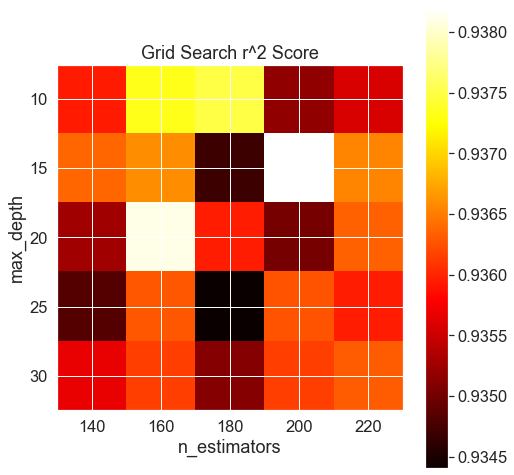

In [48]:
from sklearn.ensemble import RandomForestRegressor
nEstimator = [140,160,180,200,220]
depth = [10,15,20,25,30]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='r2',n_jobs=-1)
gsv.fit(x_train, y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=gsv.best_params_['max_depth']
nEstimators=gsv.best_params_['n_estimators']

Setelah kita mendapatkan nilai hyperparameter yang paling optimal,  kami akan membuat model dan memprediksi dengan test set yang ada

#### Random Forest dengan menggunakan Optimal Hyperparameter

In [49]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = nEstimators,max_depth=maxDepth)
model.fit(x_train, y_train)


# melakukan prediksi dengan test set yang sudah ada
y_pred = model.predict(x_test)
print('Root means squared score', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-square score: %.2f' % r2_score(y_test, y_pred))
print("Result :",model.score(x_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

Root means squared score 358112.22866281855
R-square score: 0.98
Result : 0.9844672755237212
       True Labels  Predicted Labels
30104      1171185      1.171219e+06
30105      1267640      1.302084e+06
30106      1166148      1.178079e+06
30107       819426      8.286394e+05
30108      1125692      1.124135e+06
...            ...               ...
37347       214378      2.143144e+05
37348       406828      4.056976e+05
37349       386319      3.866646e+05
37350       130263      1.311351e+05
37351      1278249      1.279348e+06

[7008 rows x 2 columns]


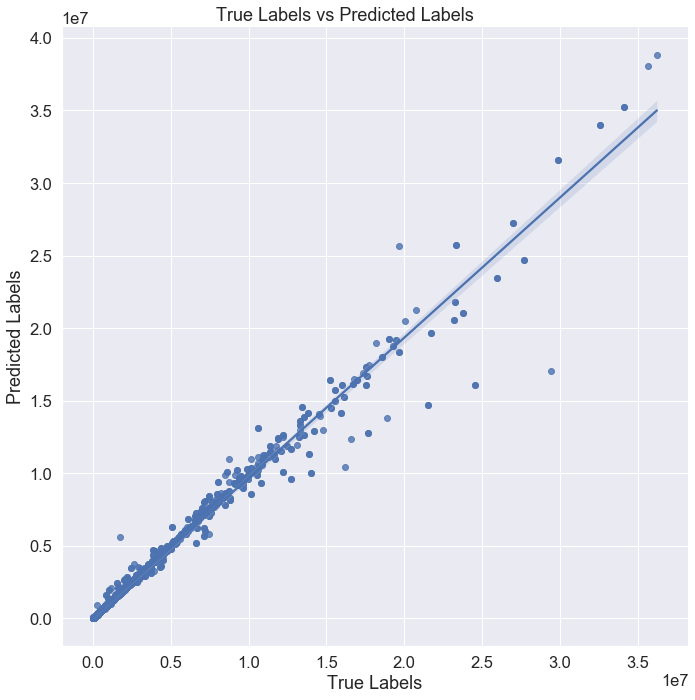

In [50]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
fig1 = lm1.fig 
fig1.suptitle("True Labels vs Predicted Labels ", fontsize=18)
sns.set(font_scale = 1.5)

Dengan memperhatikan R-square dan grafik, dapat dikatakan bahwa hasil prediksi tergolong baik.

#### 5.1.3 Linear Regression dengan Transformasi Log
#### Membagi data menjadi train data dan test data dengan ratio 80:20

In [51]:
views_log=youtube['views_log']
youtube_views_log=youtube.drop(['views_log','views','likes','comment_count','dislikes',
                           'Ratio_View_likes','Ratio_views_comment_count',
                           'Ratio_View_dislikes','Ratio_likes_dislikes'],axis=1,inplace=False)

In [52]:
x_train,x_test,y_train,y_test=train_test_split(youtube_views_log,views_log, test_size=0.2,shuffle=False)

In [53]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(28031, 15) (7008, 15) (28031,) (7008,)


#### Melakukan Linear Regression
Langkah yang dilakukan tidak berbeda dengan langkah pada 5.1.1

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Melakukan training pada model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
# Mengeluarkan koefisien
coeff_df = pd.DataFrame(model.coef_, youtube_views_log.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
category_id,-2.956528e-03
comments_disabled,2.692681e-14
ratings_disabled,3.219647e-15
video_error_or_removed,-3.366013e-01
No_tags,-4.260831e-04
desc_len,2.472370e-05
len_title,3.377319e-03
publish_weekday,-5.138874e-03
likes_log,8.633157e-01
dislikes_log,3.702485e-01


Karena kita telah melakukan transformasi logaritma pada feature view dan juga feature likes, dengan nilai koefisien 0.863 pada likes_log, maka setiap bertambahnya 1% jumlah likes, jumlah views akan bertambah sebanyak 0.9% jumlah views. Cara intepretasi ini juga berlaku untuk feature lain yang melakukan transformasi logaritma. Untuk mengintepretasikan kaitan dengan feature yang tidak di transform seperti panjang judul, maka kita harus melakukan eksponensiasi koefisien, kurangi dengan 1, dan kalikan 100. Koefisien panjang judul adalah 0.00337, maka (exp(0.00337) – 1) * 100 = 0.338. Jadi, setiap pertambahan 1 unit pada panjang judul, maka jumlah views bertambah sebanyak 33.8% 

In [56]:
# Melakukan prediksi
y_pred = model.predict(x_test)
print('Root mean squared error score', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-square score: %.2f' % r2_score(y_test, y_pred))
print("Result :",model.score(x_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

Root mean squared error score 0.448238575894958
R-square score: 0.89
Result : 0.8912869760122547
       True Labels  Predicted Labels
30104    13.973527         14.081429
30105    14.052668         13.681413
30106    13.969217         13.683911
30107    13.616361         14.095880
30108    13.933909         13.398936
...            ...               ...
37347    12.275501         12.683809
37348    12.916148         12.178662
37349    12.864421         12.343216
37350    11.777318         11.729945
37351    14.061003         14.065304

[7008 rows x 2 columns]


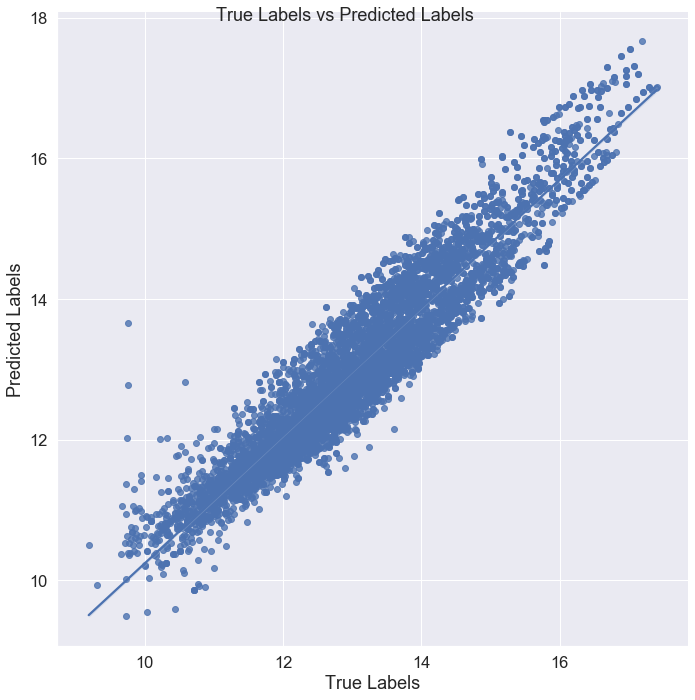

In [57]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
fig1 = lm1.fig 
fig1.suptitle("True Labels vs Predicted Labels ", fontsize=18)
sns.set(font_scale = 1.5)

Dari nilai R-square 0.89, RMSE yang sangat kecil, perbedaan nilai sebenarnya dan nilai prediksi yang minim, kami dapat melihat perbedaaan yang cukup signifikan dari prediksi menggunakan Linear Regression tanpa Transformasi Logaritma. Hasil yang didapatkan tergolong baik.

### 5.2 Prediksi Likes
####  5.2.1 Linear Regression tanpa Transformasi Log

Membagi data menjadi train data dan test data dengan ratio 80:20

In [58]:
likes=youtube['likes']
youtube_like=youtube.drop(['likes','views_log','likes_log','comment_log','dislikes_log',
                           'Ratio_View_log_likes_log','Ratio_views_log_comment_log',
                           'Ratio_View_log_dislikes_log','Ratio_likes_log_dislikes_log'],axis=1,inplace=False)

In [59]:
x_train,x_test,y_train,y_test=train_test_split(youtube_like,likes, test_size=0.2,shuffle=False)


In [60]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(28031, 15) (7008, 15) (28031,) (7008,)


#### Melakukan Linear Regression
Kami akan memuat library yang akan digunakan untuk melakukan regresi linear terlebih dahulu, lalu melakukan train pada model

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
coeff_df = pd.DataFrame(model.coef_, youtube_like.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
category_id,-2.995066e+02
views,1.567403e-02
dislikes,-1.852979e+00
comment_count,4.749600e+00
comments_disabled,-2.018337e-08
ratings_disabled,-3.916871e-08
video_error_or_removed,5.737018e+04
No_tags,-2.148417e+02
desc_len,-6.798766e-01
len_title,-2.832916e+02


Dapat dilihat bahwa setiap bertambahnya jumlah views sebanyak 1 unit, jumlah likes bertambah sebanyak 1.57 unit. 

Setelah itu, kami akan melakukan prediksi dengan test set dan membandingkan nilai sebenarnya dengan nilai prediksi

In [63]:
y_pred = model.predict(x_test)
print('Root means squared score', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-square score: %.2f' % r2_score(y_test, y_pred))
print("Result :",model.score(x_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

Root means squared score 64213.54143967579
R-square score: 0.42
Result : 0.42382963363865167
       True Labels  Predicted Labels
30104        35108      29924.980069
30105        25574      27843.932862
30106         6145      26716.495076
30107        29744      17110.261101
30108         5317      11029.684768
...            ...               ...
37347         3291      -3691.262242
37348         1726      25633.984212
37349         1216      11385.506925
37350          698       3375.870028
37351        22466      22574.168120

[7008 rows x 2 columns]


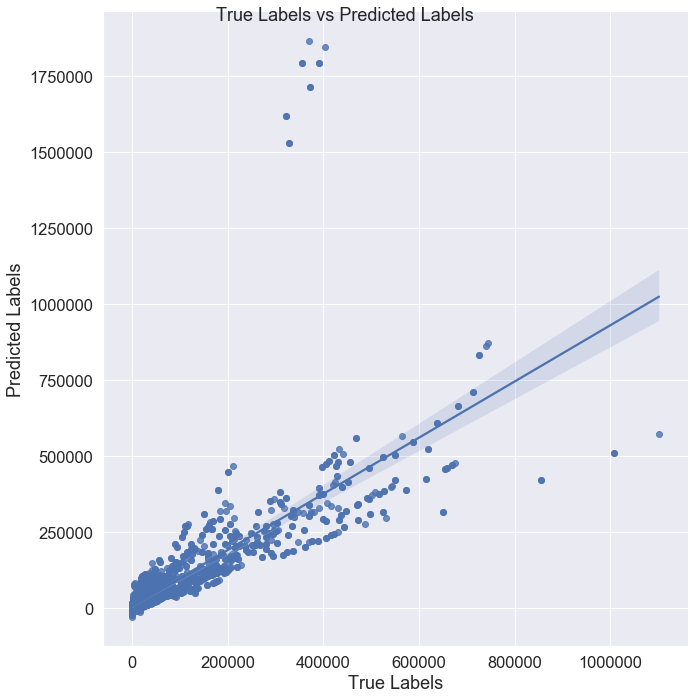

In [64]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
fig1 = lm1.fig 
fig1.suptitle("True Labels vs Predicted Labels ", fontsize=18)
sns.set(font_scale = 1.5)

Setelah melihat nilai R-square yang dibawah 0.5, dan perbedaan antara nilai prediksi terhadap nilai asli yang lumayan berbeda, maka bisa dikatakan hasil prediksi tidak terlalu bagus

#### 5.2.2 Random Forest
#### Hyper-parameter Tuning

Kami akan mencari hyperparameter yang tepat dengan menggunakan GridSeach dengan Cross Validation (GridSearchCV) untuk melakukan semua kombinasi yang ada.
Kami menggunakan cv=5 agar mengurangi kemungkinan terjadinya overfitting.

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 16.5min finished


Best HyperParameter:  {'max_depth': 25, 'n_estimators': 140}
0.9500271566313063


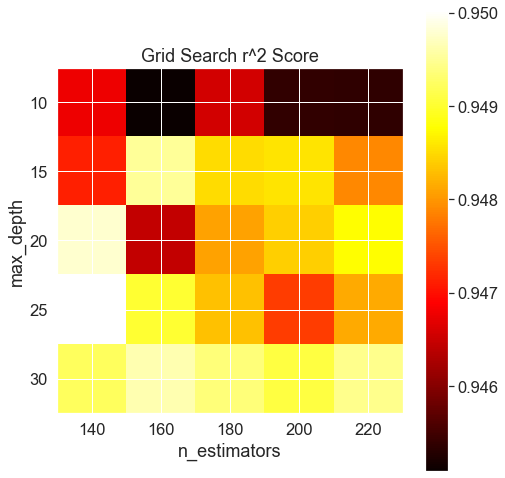

In [65]:
from sklearn.ensemble import RandomForestRegressor

nEstimator = [140,160,180,200,220]
depth = [10,15,20,25,30]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='r2',n_jobs=-1)
gsv.fit(x_train, y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=gsv.best_params_['max_depth']
nEstimators=gsv.best_params_['n_estimators']

Setelah kita mendapatkan nilai hyperparameter yang paling optimal,  kami akan membuat model dan memprediksi dengan test set yang ada

#### Random Forest dengan menggunakan Optimal Hyperparameter

In [66]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = nEstimators,max_depth=maxDepth)
model.fit(x_train, y_train)


# Melakukan prediksi dengan test set
y_pred = model.predict(x_test)
print('Root means squared score', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-square score: %.2f' % r2_score(y_test, y_pred))
print("Result :",model.score(x_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)


Root means squared score 17520.981014103167
R-square score: 0.96
Result : 0.9571042257360309
       True Labels  Predicted Labels
30104        35108      35348.007143
30105        25574      26220.607143
30106         6145       6631.692857
30107        29744      30036.064286
30108         5317       5338.207143
...            ...               ...
37347         3291       3383.535714
37348         1726       1744.957143
37349         1216       1354.821429
37350          698        700.907143
37351        22466      22097.392857

[7008 rows x 2 columns]


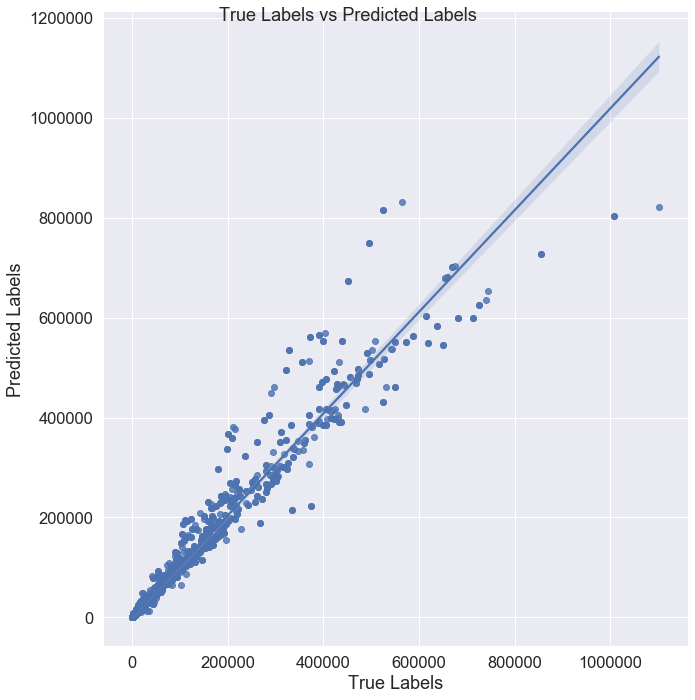

In [67]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
fig1 = lm1.fig 
fig1.suptitle("True Labels vs Predicted Labels", fontsize=18)
sns.set(font_scale = 1.5)


Dengan memperhatikan R-square dan grafik, dapat dikatakan bahwa hasil prediksi tergolong baik.

#### 5.2.3 Linear Regression dengan Transformasi Log
#### Membagi data menjadi train data dan test data dengan ratio 80:20

In [68]:
likes_log=youtube['likes_log']
youtube_likes_log=youtube.drop(['likes_log','views','likes','comment_count','dislikes',
                           'Ratio_View_likes','Ratio_views_comment_count',
                           'Ratio_View_dislikes','Ratio_likes_dislikes'],axis=1,inplace=False)

In [69]:
x_train,x_test,y_train,y_test=train_test_split(youtube_likes_log,likes_log, test_size=0.2,shuffle=False)

In [70]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(28031, 15) (7008, 15) (28031,) (7008,)


#### Melakukan Linear Regression
Langkah yang dilakukan tidak berbeda dengan langkah pada 5.2.1

In [71]:
#Memuat library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
# Mengeluarkan koefisien
coeff_df = pd.DataFrame(model.coef_, youtube_likes_log.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
category_id,-7.838916e-03
comments_disabled,1.227143e-14
ratings_disabled,5.551115e-17
video_error_or_removed,5.373407e-02
No_tags,8.789495e-04
desc_len,7.171624e-06
len_title,-2.886753e-03
publish_weekday,-1.931820e-04
views_log,3.777014e-01
dislikes_log,3.987270e-01


Koefisien view_log adalah 0.378, maka setiap pertambahan 1% views, akan bertambah 0.378% likes.

In [73]:
#Melakukan prediksi dengan test set
y_pred = model.predict(x_test)
print('Root means squared score', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-square score: %.2f' % r2_score(y_test, y_pred))
print("Result :",model.score(x_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

Root means squared score 0.2442462701651499
R-square score: 0.98
Result : 0.9823106824363809
       True Labels  Predicted Labels
30104    10.466213         10.221053
30105    10.149371          9.841565
30106     8.723557          9.146529
30107    10.300416         10.041254
30108     8.578853          8.727661
...            ...               ...
37347     8.099251          7.892199
37348     7.454141          8.151320
37349     7.104144          7.666917
37350     6.549651          6.515921
37351    10.019803          9.843786

[7008 rows x 2 columns]


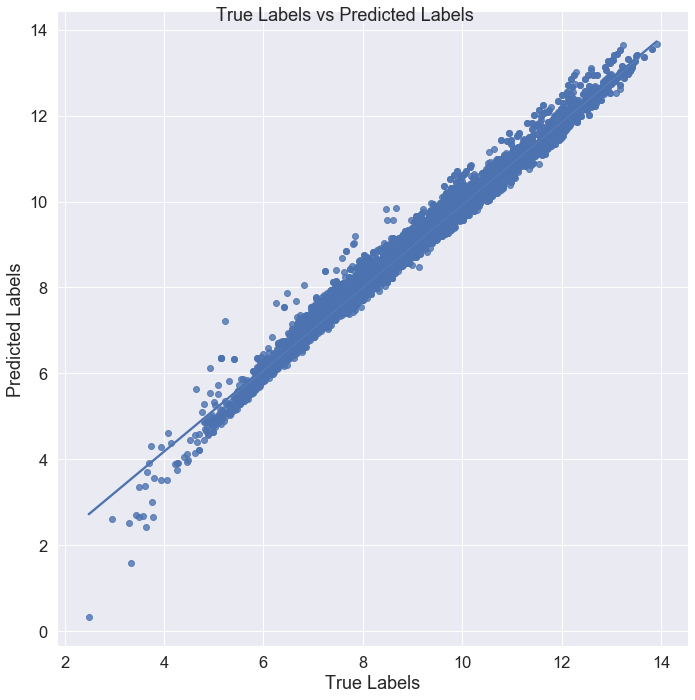

In [74]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
fig1 = lm1.fig 
fig1.suptitle("True Labels vs Predicted Labels ", fontsize=18)
sns.set(font_scale = 1.5)

Dari nilai R-square 0.98, nilai akurasi 0.983 dan grafik nilai prediksi terhadap hasil prediksi,  kami dapat melihat hasil yang positif. Terdapat perbedaaan yang cukup signifikan dari prediksi menggunakan Linear Regression tanpa Transformasi Logaritma. Hasil yang didapatkan tergolong baik.

### 5.3 Prediksi Jumlah Komentar 
####  5.3.1 Linear Regression tanpa Transformasi Logaritma

Membagi data menjadi train data dan test data dengan ratio 80:20

In [75]:
comment_count=youtube['comment_count']
youtube_comment=youtube.drop(['comment_count', 'views_log','likes_log','comment_log','dislikes_log',
                           'Ratio_View_log_likes_log','Ratio_views_log_comment_log',
                           'Ratio_View_log_dislikes_log','Ratio_likes_log_dislikes_log'
],axis=1,inplace=False)

In [76]:
x_train,x_test,y_train,y_test=train_test_split(youtube_comment,comment_count, test_size=0.2,shuffle=False)

In [77]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(28031, 15) (7008, 15) (28031,) (7008,)


Melakukan Linear Regression
Kami akan memuat library yang akan digunakan untuk melakukan regresi linear terlebih dahulu, lalu melakukan train pada model

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
coeff_df = pd.DataFrame(model.coef_, youtube_comment.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
category_id,1.010235e+02
views,-4.051461e-04
likes,9.598017e-02
dislikes,4.198610e-01
comments_disabled,4.039813e-11
ratings_disabled,1.715913e-11
video_error_or_removed,-6.196624e+01
No_tags,9.585068e+00
desc_len,-2.243238e-01
len_title,8.543266e+00


Dapat dilihat, setiap bertambahnya 1 unit jumlah likes, maka jumlah komentar bertambah sebanyak 0.096 unit.

Setelah itu, kami akan melakukan prediksi dengan test set dan membandingkan nilai sebenarnya dengan nilai prediksi

In [80]:
y_pred = model.predict(x_test)
print('Root means square score', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-square score: %.2f' % r2_score(y_test, y_pred))
print("Result :",model.score(x_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

Root means square score 13445.005828509136
R-square score: 0.35
Result : 0.35291468214321664
       True Labels  Predicted Labels
30104         1935       3451.453519
30105         1006       2410.122406
30106          682        148.582201
30107         1549       1852.446516
30108          391        409.544326
...            ...               ...
37347          196        348.217474
37348         1428       -342.577770
37349          697       -480.984657
37350           65        -81.098963
37351         1205       2275.096325

[7008 rows x 2 columns]


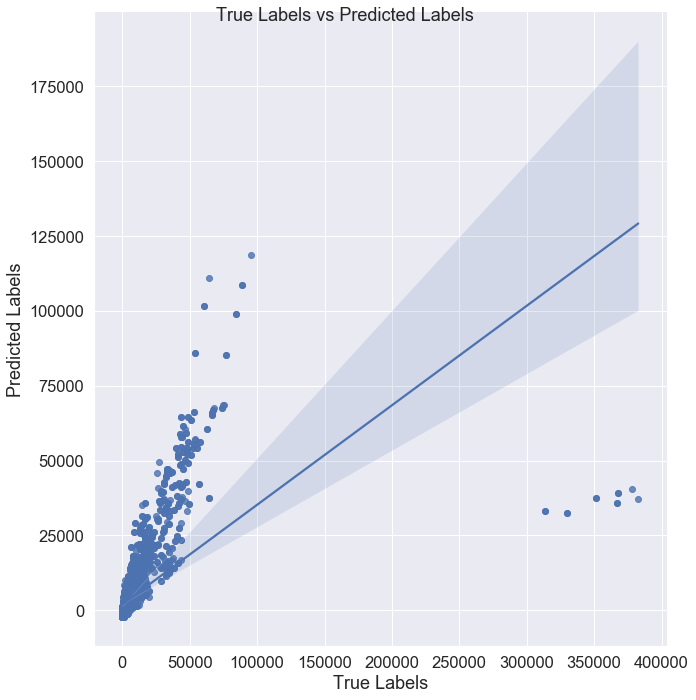

In [81]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
fig1 = lm1.fig 
fig1.suptitle("True Labels vs Predicted Labels ", fontsize=18)
sns.set(font_scale = 1.5)

Dari nilai R-square 0.35 dan grafik, kami dapat menyimpulkan bahwa hasil model kami tidak terlalu bagus mengingat R-square yang didapatkan lebih kecil dari 0.5. Ditambah lagi perbedaan yang cukup besar antara nilai prediksi terhadap hasil menyebabkan hasil prediksi ini tidak terlalu bagus

#### 5.3.2 Random Forest
#### Hyper-parameter Tuning

Masih dengan menggunakan training set dan test set yang sama, kami akan mencari hyperparameter yang tepat dengan menggunakan GridSeach dengan Cross Validation (GridSearchCV) untuk melakukan semua kombinasi yang ada.
Kami menggunakan cv=5 agar mengurangi kemungkinan terjadinya overfitting.

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 17.9min finished


Best HyperParameter:  {'max_depth': 30, 'n_estimators': 140}
0.8390810091926137


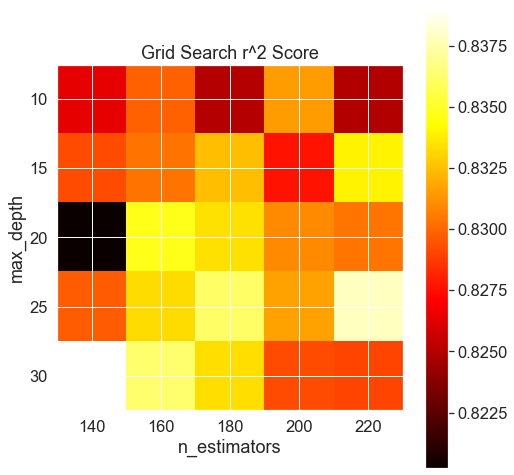

In [82]:
nEstimator = [140,160,180,200,220]
depth = [10,15,20,25,30]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='r2',n_jobs=-1)
gsv.fit(x_train, y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=gsv.best_params_['max_depth']
nEstimators=gsv.best_params_['n_estimators']

Setelah kita mendapatkan nilai hyperparameter yang paling optimal,  kami akan membuat model dan memprediksi dengan test set yang ada

#### Random Forest dengan menggunakan Optimal Hyperparameter

In [83]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = nEstimators,max_depth=maxDepth)
model.fit(x_train, y_train)


# predicting the  test set results
y_pred = model.predict(x_test)
print('Root means squared score', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-square score: %.2f' % r2_score(y_test, y_pred))
print("Result :",model.score(x_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

Root means squared score 7432.446548101171
R-square score: 0.80
Result : 0.8022560771597027
       True Labels  Predicted Labels
30104         1935       1975.128571
30105         1006        978.114286
30106          682        705.735714
30107         1549       1533.478571
30108          391        388.671429
...            ...               ...
37347          196        199.485714
37348         1428       1462.435714
37349          697        700.335714
37350           65         64.492857
37351         1205       1189.935714

[7008 rows x 2 columns]


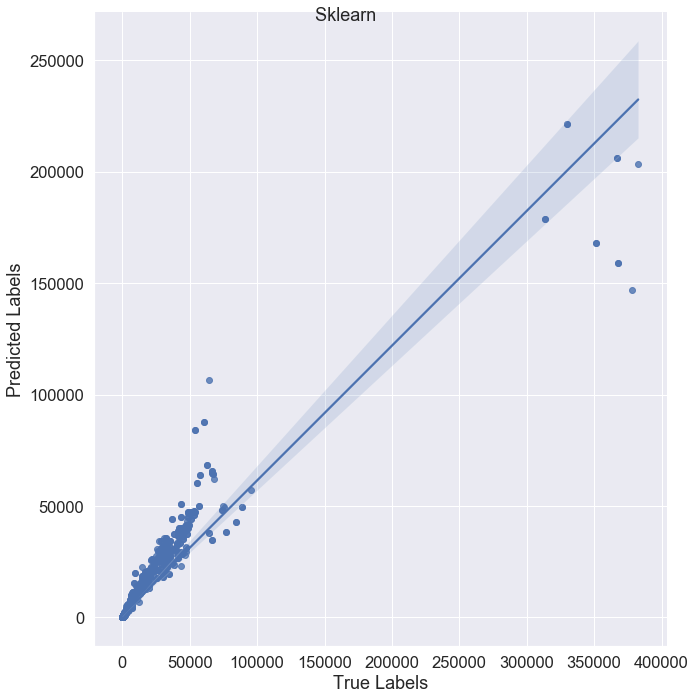

In [84]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
fig1 = lm1.fig 
fig1.suptitle("Sklearn ", fontsize=18)
sns.set(font_scale = 1.5)

Dengan memperhatikan R-square dan grafik, dapat dikatakan bahwa hasil prediksi tergolong baik.

#### 5.3.3 Linear Regression dengan Transformasi Log

In [85]:
comment_log=youtube['comment_log']
youtube_comment_log=youtube.drop(['comment_log', 'views','likes','comment_count','dislikes',
                           'Ratio_View_likes','Ratio_views_comment_count',
                           'Ratio_View_dislikes','Ratio_likes_dislikes'
],axis=1,inplace=False)

In [86]:
x_train,x_test,y_train,y_test=train_test_split(youtube_comment_log,comment_log, test_size=0.2,shuffle=False)

In [87]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(28031, 15) (7008, 15) (28031,) (7008,)


#### Melakukan Linear Regression
Langkah yang dilakukan tidak berbeda dengan langkah pada 5.3.1

In [88]:
#Memuat library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [89]:
# Mengeluarkan koefisien
coeff_df = pd.DataFrame(model.coef_, youtube_comment_log.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
category_id,1.165705e-02
comments_disabled,8.960931e-14
ratings_disabled,-1.387779e-16
video_error_or_removed,6.177008e-01
No_tags,2.002072e-04
desc_len,1.252311e-05
len_title,-4.473322e-04
publish_weekday,-2.002130e-03
likes_log,8.204012e-01
views_log,-3.204237e-01


Dapat diihat setiap bertambahnya 1 unit likes, maka jumlah komentar bertambah 0.8%

In [90]:
#Melakukan prediksi dengan test set
y_pred = model.predict(x_test)
print('Root means square score', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-square score: %.2f' % r2_score(y_test, y_pred))
print("Result :",model.score(x_test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

Root means square score 0.5178476461643506
R-square score: 0.92
Result : 0.923468865977311
       True Labels  Predicted Labels
30104     7.568379          7.866482
30105     6.914731          7.187776
30106     6.526495          6.767449
30107     7.346010          7.636010
30108     5.971262          6.161535
...            ...               ...
37347     5.283204          5.837465
37348     7.264730          5.801050
37349     6.548219          5.517307
37350     4.189655          4.408757
37351     7.095064          7.498980

[7008 rows x 2 columns]


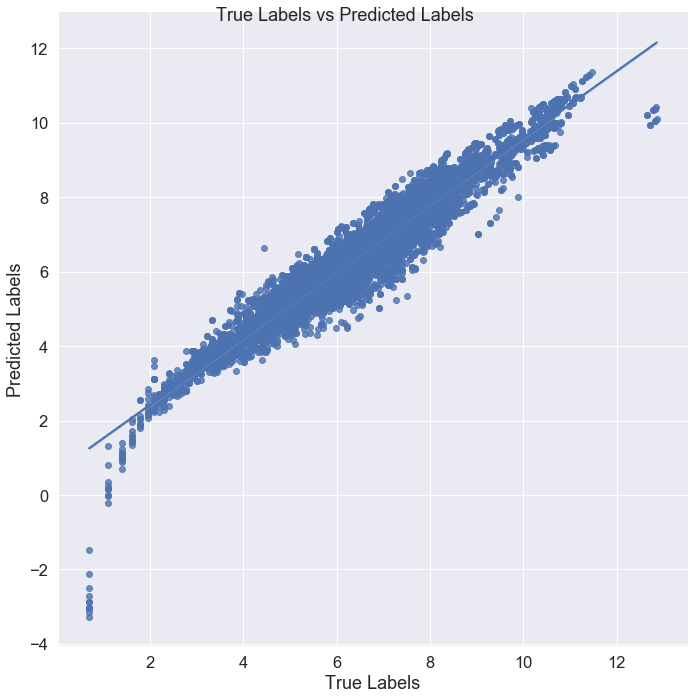

In [91]:
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
fig1 = lm1.fig 
fig1.suptitle("True Labels vs Predicted Labels ", fontsize=18)
sns.set(font_scale = 1.5)

Dari nilai R-square 0.92 yang berarti mendekati 1, tingkat akurasi 92%, dan perbedaan nilai prediksi dan nilai asli juga tidak jauh berbeda, maka kami dapat menyimpulkan bahwa hasil model kami tergolong baik. 

## 6 Hasil

Untuk menganalisis hasil dari model yang telah kami buat, kami akan membandingkan R-square dan tingkat akurasi (Result) yang didapatkan. Nilai R-square dan Result berkisar dari 0 hingga 1. Apabila mendekati 1, maka semakin baik hasil prediksi kami.

### 6.1 Prediksi Views

|Model| |R-square| |Result|
|---| |---| |---|
|Linear Regression tanpa Transformasi Log| |0,73| |0,734|
|Random Forest| |0,98| |0,984|
|Linear Regression dengan Transformasi Log| |0,89| |0,891|

Dari data yang ada, kita dapat melihat bahwa model prediksi dengan Linear Regression tanpa transformasi log mendapat r-square 0.73 dn tingkat akurasi 73%, Random Forest mendapat 0.98 dan 98%, dan Linear Regression dengan Transformasi Logaritma memiliki nilai R-square dan result yakni 0.89 dan 89% secara berurutan.Jika dilihat secara keseluruhan maka model terbaik untuk memprediksi views pada sebuah video di youtube adalah Random Forest.

### 6.2 Prediksi Likes

|Model| |R-square| |Hasil|
|---| |---| |---|
|Linear Regression tanpa Transformasi Log| |0,42| |0,423|
|Random Forest| |0,96| |0,957|
|Linear Regression dengan Transformasi Log| |0,98| |0,982|

Dari data yang ada, kita dapat melihat bahwa model prediksi dengan Linear Regression tanpa transformasi log mendapat r-square 0.42 dan tingkat akurasi 42%. Hasil yang didapatkan tidak terlalu bagus. Random Forest mendapat 0.98 dan 98%, dan Linear Regression dengan Transformasi Logaritma memiliki nilai R-square dan result yakni 0.98 dan 98.3% secara berurutan.Jika dilihat secara keseluruhan maka model terbaik untuk memprediksi likes pada sebuah video di youtube adalah Linear Regression dengan Transformasi Logaritma.

### 6.3 Prediksi Jumlah Komentar

|Model| |R-square| |Hasil|
|---| |---| |---|
|Linear Regression tanpa Transformasi Log| |0,35| |0,352]|
|Random Forest| |0,80| |0,802|
|Linear Regression dengan Transformasi Log| |0,92| |0,923|

Dari data yang ada, kita dapat melihat bahwa model prediksi dengan Linear Regression tanpa transformasi log mendapat r-square 0.35 dan tingkat akurasi 35%. Hasil yang didapatkan tidak terlalu bagus. Random Forest mendapat 0.81 dan 81%, dan Linear Regression dengan Transformasi Logaritma memiliki nilai R-square dan result yakni 0.92 dan 92.3% secara berurutan.Jika dilihat secara keseluruhan maka model terbaik untuk memprediksi jumlah komentar pada sebuah video di youtube adalah Linear Regression dengan Transformasi Logaritma.

## 7 Kesimpulan dan Saran

### 7.1 Kesimpulan
Untuk melakukan prediksi pada views, likes, dan jumlah komentar pada suatu video dalam Youtube, penggunaann Linear Regression dengan Transformasi Logaritma adalah pilihan terbaik, karena hasil yang didapatkan pun cukup sesuai. Selain itu, _running time_ yang dimiliki juga lebih singkat. Pilihan kedua adalah dengan random forest. Penggunaan linear regression tanpa transformasi log kurang disarankan karena hasil prediksi kurang sesuai dan linear regression tidak dapat mengatasi data yang tidak berdistribusi normal, tidak seperti random forest.

### 7.2 Saran
- Dalam penelitian selanjutnya, sebaiknya data yang kurang berkorelasi dapat Kami menggunakan data pada tahun 2017 - 2018 yang tergolong cukup lama. Padahal, algoritma Youtube dapat berubah sewaktu-waktu dan memungkinkan terjadinya pola dalam melakukan prediksi. Oleh karena itu, kami menyarankan untuk melakukan prediksi dengan data terbaru agar hasil yang didapatkan lebih relevan.
- Perbedaan hasil yang didapatkan dapat disebabkan oleh terlalu banyaknya fitur yang digunakan. Sebaiknya peneliti selanjutnya menentukan batas minimum tingkat korelasi variable sebelum melakukan model prediksi 